### Problem 1

$$
Y|\beta \sim \mathcal{N}(X\beta, \sigma_\epsilon^2 I_n)
$$
$$
\beta \sim \mathcal{N}(0, \sigma_\beta^2 I_p)
$$
Denote $a = \frac{1}{\sigma_\beta^2}$ and $b = \frac{1}{\sigma_\epsilon^2}$.

We have the exact posterior distribution:

$$
\beta | Y \sim \mathcal{N}(\mu, \Sigma)
$$
where 
$$
\mu = \left(\frac{a}{b} I + X^T X\right)^{-1} X^T Y, \quad \Sigma = \left(a + b X^T X\right)^{-1}
$$

$$
\log P(Y;a, b) = -\frac{1}{2} \left[
\log |\frac{1}{a}XX^T + \frac{1}{b}I_n| + Y^T (\frac{1}{a}XX^T + \frac{1}{b}I_n)^{-1} Y + p \log(2\pi)
\right]
$$

We can also approximate this posterior distribution by mean-field:
$$
q(\beta) = \sum_{j=1}^p q_j(\beta_j)
$$

$$
\log q(\beta_j) = \mathbb{E}_{i\neq j}[\log p(Y, \beta)] + \text{const}\\
=-\frac{1}{2}\left(b \sum_{i=1}^n X_{ij}^2 + a\right) \beta_j^2 + b \sum_{i=1}^n \left(Y_i X_{ij} - \sum_{k\neq j}X_{ik}\mathbb{E}[\beta_k]X_{i,j}\right) \beta_j + \text{const}
$$

This implies that $\beta_j \sim \mathcal{N}(\mu_j, \sigma^2_j)$, 
where 
$$
\mu_j = \frac{b \sum_{i=1}^n \left(Y_i X_{ij} - \sum_{k\neq j}X_{ik}\mu_kX_{i,j}\right)}{b \sum_{i=1}^n X_{ij}^2 + a}, \quad \sigma^2_j = \frac{1}{b\sum_{i=1}^n X_{ij}^2 + a}.
$$

Next, we use simulation to verify that the posterior mean obtained by mean-field is accurate while the posterior variance is underestimated.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from numpy.random import default_rng
rng = default_rng()

In [2]:
# Generate data using my favorite statistical model
class DataGen:
    def __init__(self, n=1000, p=100, sigma_e=10, seed=1):
        rng = default_rng(seed)
        X = rng.standard_normal((n, p))
        beta = rng.standard_normal(p)/np.sqrt(p)
        e = rng.standard_normal(n)*sigma_e
        Y0 = X.dot(beta)
        Y = Y0 + e 
        self.X = X
        self.Y = Y
        self.beta = beta
        self.a_truth = p 
        self.b_truth = sigma_e**(-2)

In [3]:
class MF:
    def __init__(self, X, y, tol=1e-6):
        self.X = X
        self.y = y 
        self.n, self.p = self.X.shape
        self.tol = tol 
        
    def var(self, a, b):
        return 1.0/(a + b*(self.X**2).sum(axis=0))
    
    def mu(self, a, b):
        coef = b*self.var(a, b)
        tmp = self.y.dot(self.X)
        mu = np.random.random(self.p)
        while True:
            tmp2 = self.X.dot(mu).dot(self.X) - ((self.X**2)*mu).sum(axis=0)
            mu_update = coef*(tmp - tmp2)
            if np.linalg.norm(mu_update - mu, ord=1) < self.tol:
                break
            mu = mu_update
        return mu

In [4]:
class EM:
    def __init__(self, X, y):
        self.X = X 
        self.y = y 
        self.n, self.p = self.X.shape 
        
    def mu_r(self, a, b):
        X = self.X
        y = self.y
        return np.linalg.inv(a/b*np.eye(self.p) + X.T@X)@X.T@y
    
    def sigma_r(self, a, b):
        return np.linalg.inv(a + b*self.X.T@self.X)
    
    def llh(self, a, b):
        X = self.X
        tmp = X@X.T/a + np.identity(self.n)/b
        sign, logdet = np.linalg.slogdet(tmp)
        t = logdet + self.y.T@np.linalg.inv(tmp)@self.y + self.n*np.log(2*np.pi)
        return -1/2*t
    
    def solver(self, a0, b0, tol=1e-6):
        X, y = self.X, self.y
        llhs = []
        llhs.append(self.llh(a0, b0))
        a, b = a0, b0 
        while True:
            mu = self.mu_r(a, b)
            sigma = self.sigma_r(a, b)
            a = self.p/(mu.T@mu + np.trace(sigma))
            b = self.n/(np.linalg.norm(y-X@mu)**2 + np.trace(X.T@X@sigma))
            llhs.append(self.llh(a, b))
            if np.abs((llhs[-1]-llhs[-2])/llhs[-2]) < tol:
                break
        return a, b, llhs

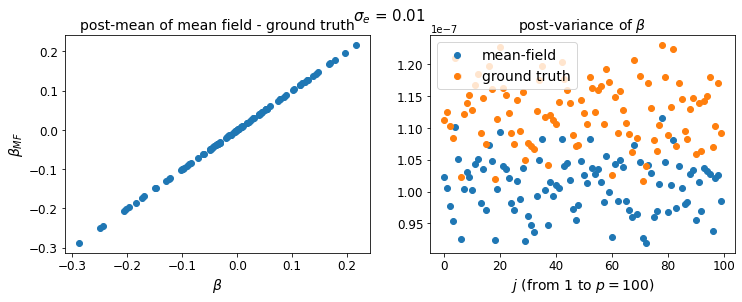

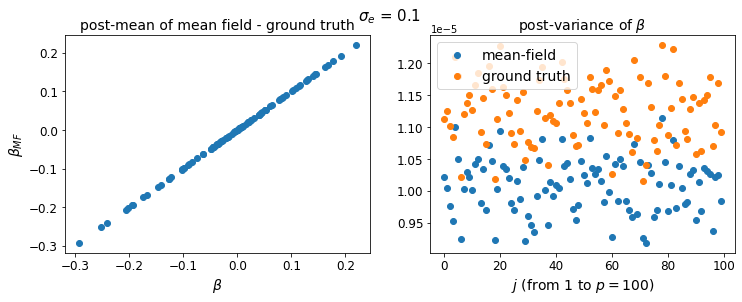

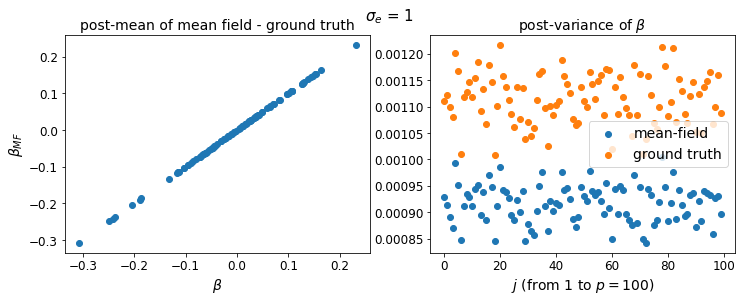

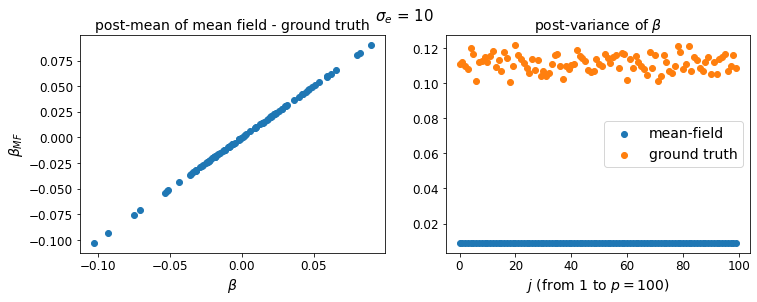

In [5]:
sigma_e_list = [0.01, 0.1, 1, 10]
for sigma_e in sigma_e_list:
    data = DataGen(1000, 100, sigma_e=sigma_e)

    mf_model = MF(data.X, data.Y)
    em_model = EM(data.X, data.Y)


    beta_mf = mf_model.mu(data.a_truth, data.b_truth)
    beta_em = em_model.mu_r(data.a_truth, data.b_truth)

    var_mf = mf_model.var(data.a_truth, data.b_truth)
    var_em = np.diagonal(em_model.sigma_r(data.a_truth, data.b_truth))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].scatter(beta_mf, beta_em)
    ax[1].set_title('post-variance of $\\beta$', fontsize=14)
    ax[0].set_xlabel('$\\beta$', fontsize=14) 
    ax[0].set_ylabel('$\\beta_{MF}$', fontsize=14)
    ax[0].set_title('post-mean of mean field - ground truth', fontsize=14)
    ax[0].tick_params(labelsize=12)
    ax[1].scatter(np.arange(data.X.shape[1]), var_mf, label='mean-field')
    ax[1].scatter(np.arange(data.X.shape[1]),var_em, label='ground truth')
    ax[1].set_title('post-variance of $\\beta$', fontsize=14)
    ax[1].set_xlabel('$j$ (from $1$ to $p=100$)', fontsize=14) 
    ax[1].tick_params(labelsize=12)
    plt.legend(fontsize=14)
    plt.suptitle(f'$\\sigma_e$ = {sigma_e}', fontsize=15)
    plt.show()

#### Discussion

In my simulation, I verified that the posterior mean is accurate while the posterior variance is underestimated. I also find that the noise $\sigma_e$ affect the quality of posterior variance estiamtion of mean-field. The stronger noise $\sigma_e$ is, the more underestimation is. Meanwhile, the posterior mean estimation is always accurate enough.